# Elo Merchant Category Recommendation
Ridge regression prediction with LynxKite of the [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest. The contents of the shared files can be read here:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and prediction
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In this section we will create visualizations of the input data to gain a comprehensive insight to the properties of the data.
* [Train and test data](#Train-and-test-data) Data of customers' cards
    * [card_id](#card_id)
    * [first_active_month](#first_active_month)
    * [feature_1,-feature_2,-feature_3](#feature_1, feature_2, feature_3)
    * [target](#target)
* [Transactions](#Transactions) Card transactions for both train and test data
    * [authorized_flag](#authorized_flag)
    * [card_id](#card_id)
    * [state_id, city_id](#state_id, city_id)
    * [category_1, category_2, category_3](#category_1, category_2, category_3)
    * [installments, purchase_amount](#installments, purchase_amount)
    * [merchant_id, merchant_category_id, subsector_id](#merchant_id, merchant_category_id, subsector_id)
    * [month_lag](#month_lag)
    * [purchase_date](#purchase_date)
* [Merchants](#Mechants) Data of merchants

In [1]:
import os
import gc
import scipy
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
from IPython.core.display import display, HTML
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings("ignore")

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Train and test data
The training and test data sets contain card_ids and information about the card itself.

In [3]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")
print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

201,917 records and 6 features in train set.
123,623 records and 5 features in test set.
Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)


In [4]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988


In [5]:
df_test[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1


The only difference between the training and test data set is the test data set does not have target variable. Now we will check the variables one by one.

#### card_id

In [6]:
df_train[df_train['card_id'].isin(df_test['card_id'].values)]

,first_active_month,card_id,feature_1,feature_2,feature_3,target


Double checked that the training and the test set of card_ids don't have an intersect

In [7]:
print("Number of unique card IDs in the training set: {:,}".format(len(df_train['card_id'].unique())))
print("Number of unique card IDs in the test set: {:,}".format(len(df_test['card_id'].unique())))

Number of unique card IDs in the training set: 201,917
Number of unique card IDs in the test set: 123,623


The number of unique records are exactly the same as the number of total records in both sets. This is not surprising, just a double check. So we can conclude, that we need to recommend restaurants for the same period for different customers with different cards.

#### first_active_month
Let's check the range of the `first_active_month`. In the test set, there is one NaN value for **C_ID_c27b4f80f7** `card_id`, that we need to filter out, before searching for the minimum and maximum.

In [8]:
print("The first_active_month variable in the training set is ranging from {} to {}".format(df_train['first_active_month'].min(), df_train['first_active_month'].max()))
print("The first_active_month variable in the test set is ranging from {} to {}".format(df_test[df_test['card_id'] != 'C_ID_c27b4f80f7']['first_active_month'].min(), df_test[df_test['card_id'] != 'C_ID_c27b4f80f7']['first_active_month'].max()))

The first_active_month variable in the training set is ranging from 2011-11 to 2018-02
The first_active_month variable in the test set is ranging from 2011-11 to 2018-01


It is important to know that the training set is for the same duration as the test set.

In [9]:
print("There are {} months between the start and end date of the training set.".format(len(df_train['first_active_month'].unique())))

There are 75 months between the start and end date of the training set.


In [10]:
q1_tr = int(df_train['first_active_month'].count()/4)
q3_tr = int(3*df_train['first_active_month'].count()/4)

q1_te = int(df_test['first_active_month'].count()/4)
q3_te = int(3*df_test['first_active_month'].count()/4)

df_train.sort_values(by='first_active_month', inplace=True, na_position='last')
df_test.sort_values(by='first_active_month', inplace=True, na_position='last')

print('Interquartile range of the training set: {} - {}'.format(df_train['first_active_month'].iloc[q1_tr], df_train['first_active_month'].iloc[q3_tr]))
print('Interquartile range of the test set: {} - {}'.format(df_test['first_active_month'].iloc[q1_te], df_test['first_active_month'].iloc[q3_te]))

Interquartile range of the training set: 2016-10 - 2017-09
Interquartile range of the test set: 2016-10 - 2017-09


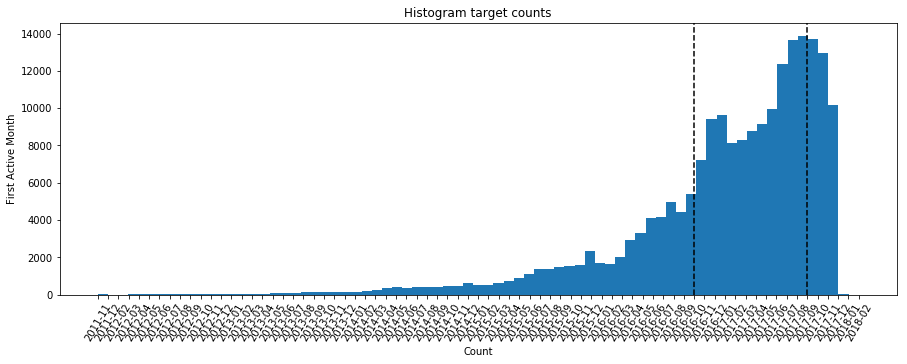

In [11]:
plt.figure(figsize=(15, 5))
plt.hist(df_train['first_active_month'].values, bins=75)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('First Active Month')
plt.axvline('2016-10', color="k", linestyle="--");
plt.axvline('2017-09', color="k", linestyle="--");
plt.show()

The interquartile range is shown on the histogram.

#### feature_1, feature_2, feature_3

In [12]:
html = '<table>'
html+= '<thead><tr><th></th><th>Training set</th><th>Test set</th></tr></thead>'
html+= '<tbody>'

html+= '<tr><td><b>Feature 1:</b></td><td>' + str(df_train['feature_1'].min()) + '-' + str(df_train['feature_1'].max()) + '</td>'
html+= '<td>' + str(df_test['feature_1'].min()) + '-' + str(df_test['feature_1'].max()) + '</td></tr>'

html+= '<tr><td><b>Feature 2:</b></td><td>' + str(df_train['feature_2'].min()) + '-' + str(df_train['feature_2'].max()) + '</td>'
html+= '<td>' + str(df_test['feature_2'].min()) + '-' + str(df_test['feature_2'].max()) + '</td></tr>'

html+= '<tr><td><b>Feature 3:</b></td><td>' + str(df_train['feature_3'].min()) + '-' + str(df_train['feature_3'].max()) + '</td>'
html+= '<td>' + str(df_test['feature_3'].min()) + '-' + str(df_test['feature_3'].max()) + '</td></tr>'

html+= '</tbody></table>'
display(HTML(html))

,Training set,Test set
Feature 1:,1-5,1-5
Feature 2:,1-3,1-3
Feature 3:,0-1,0-1


The range of the features are the same both in training and test test.

#### target

In [13]:
df_train.target.describe()

count    201917.000000
mean               NaN
std           0.000000
min         -33.218750
25%          -0.883301
50%          -0.023438
75%           0.765625
max          17.968750
Name: target, dtype: float64

The value of the target variable is ranging between -33.21 and 17.96. These number don't tell us much about the distribution of the variables, that's why we draw a histrogram of the values.

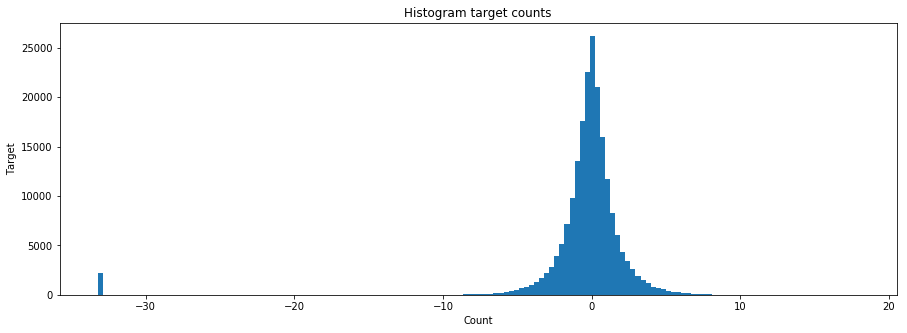

In [14]:
plt.figure(figsize=(15, 5))
plt.hist(df_train.target.values, bins=150)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

As you can see the majority of the values are between -8 and 8 and there is a spike of outliers around -33. Previously we have found out that the mean is -0.39, and the standard deviation is 3.85.

In [24]:
print('There are {:,} target elements with value {:.5f}'.format(
    df_train[df_train['target'] < -30]['target'].count(),
    df_train[df_train['target'] < -30]['target'].unique()[0]
))

There are 2,207 target elements with value -33.21875


Apparently the loyalty calculator function doesn't work properly with some of the values as input. Apart from this, if we chop off the outliers, the distribution of the target values might have normal distribution. Let's check it!

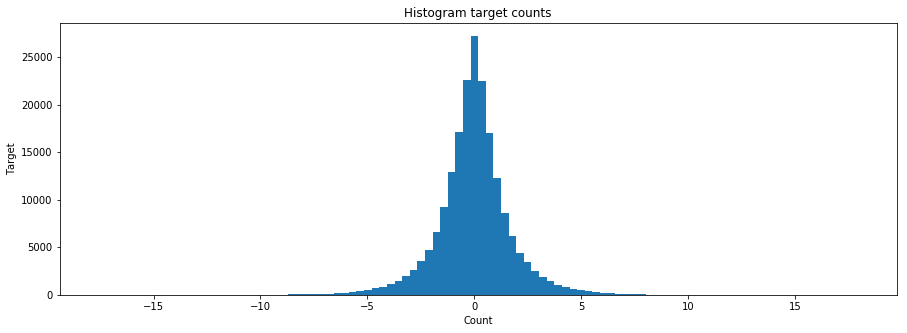

In [139]:
plt.figure(figsize=(15, 5))
plt.hist(df_train[df_train['target'] > -20].target.values, bins=100) # normal distribution
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

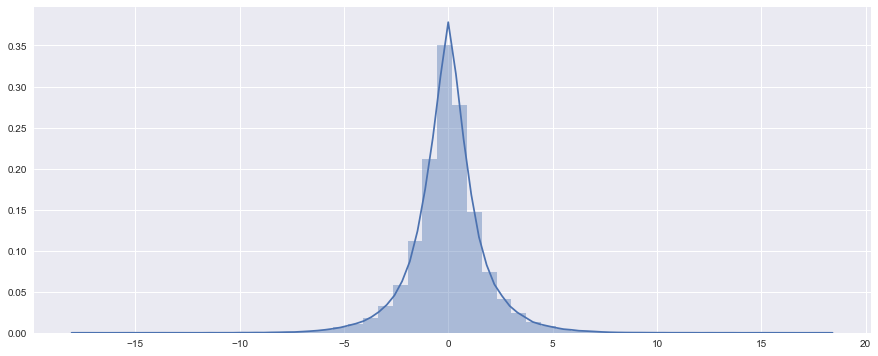

In [140]:
sns.set(rc={'figure.figsize':(15, 6)})
sns.distplot(df_train[df_train['target'] > -20].target.values)

If we draw the line of the normal distribution to the chart, looks like it has a normal distribution, but let's go further with the checking of the statistics. The QQ plot shows the scatter plot of points in a diagonal line, closely fitting the expected diagonal pattern for a sample from a Gaussian distribution. As the plot below shows the deviations from the red line, it seems that the distribution of the target attribute is not normal.

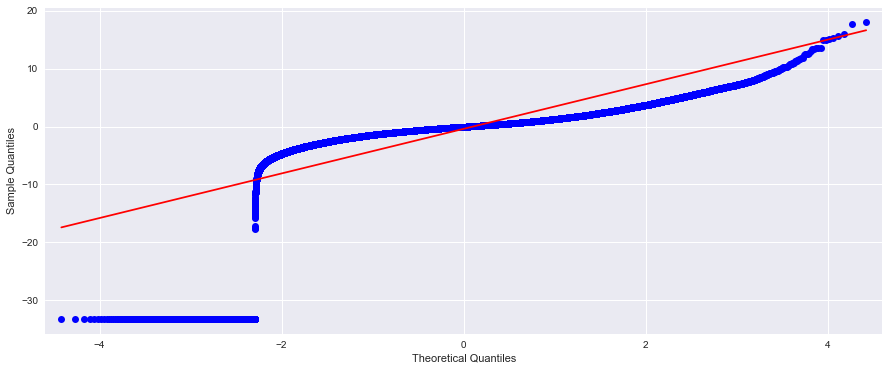

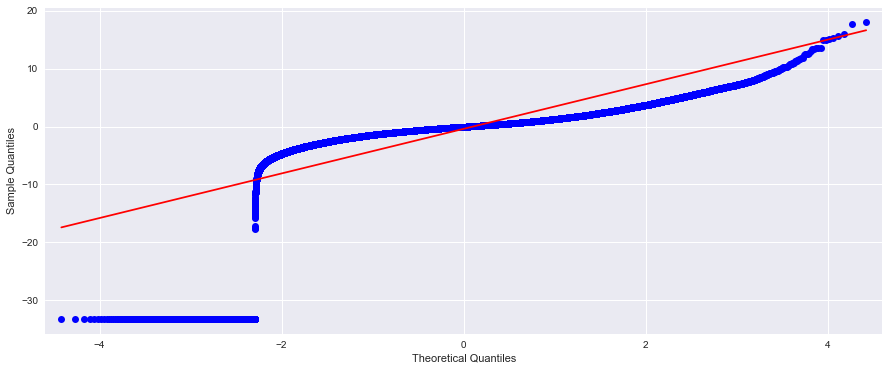

In [141]:
qqplot(df_train['target'], line='s')

In [142]:
print('Shapiro-Wilk Test normality test')
stat, p = stats.shapiro(df_train[df_train['target'] > -30].target.values)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.1
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Shapiro-Wilk Test normality test
Statistics=0.949, p=0.000
Sample does not look Gaussian (reject H0)


As the p value is zero, the target attribute (without the outliers) is not drawn from normal distribution at any confidence level.

### Transactions

In [3]:
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
print("{:,} records and {} features in historical transactions set.".format(df_hist_trans.shape[0], df_hist_trans.shape[1]))

df_hist_trans = reduce_mem_usage(df_hist_trans)

29,112,361 records and 14 features in historical transactions set.
Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)


In [4]:
df_hist_trans[:3]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37


In [5]:
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
print("{:,} records and {} features in new transactions set.".format(df_new_trans.shape[0], df_new_trans.shape[1]))

df_new_trans = reduce_mem_usage(df_new_trans)

1,963,031 records and 14 features in new transactions set.
Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)


In [6]:
df_new_trans[:3]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14


In [32]:
df_n = df_new_trans.groupby("card_id").size().reset_index().rename({0:'transactions'}, axis=1)
df_h = df_hist_trans.groupby("card_id").size().reset_index().rename({0:'transactions'}, axis=1)

In [59]:
def displayDataframesInHTMLTable(columns, rows, df):
    html = '<table>'
    html+= '<thead><tr><th>&nbsp;</th>'
    for col_item in columns:
        html+= '<th>' + str(col_item) + '</th>'
    html+= '</tr></thead><tbody>'

    for x in range(0, len(df)):
        html+= '<tr>'
        html+= '<td><b>' + rows[x] + '</b></td>'

        for y in range(0, len(df[0])):
            html+= '<td>' + df[x][y] + '</td>'
    html+= '</tr>'

    html+= '</tbody></table>'
    display(HTML(html))

In [63]:
displayDataframesInHTMLTable(
    ['Average', 'Maximum'],
    ['New transactions', 'Historical transactions'],
    [
        ['{:.4f}'.format(df_n['transactions'].mean()), '{}'.format(df_n['transactions'].max())],
        ['{:.4f}'.format(df_h['transactions'].mean()), '{}'.format(df_h['transactions'].max())]
    ]
)

,Average,Maximum
New transactions,6.7690,109
Historical transactions,89.4279,5582


#### authorized_flag

In [8]:
df_new_trans['authorized_flag'].unique(), df_hist_trans['authorized_flag'].unique()

(array(['Y'], dtype=object), array(['Y', 'N'], dtype=object))

#### card_id

#### state_id, city_id

#### category_1, category_2, category_3

#### installments, purchase_amount

#### merchant_id, merchant_category_id, subsector_id

#### month_lag

#### purchase_date

### Merchants

In [7]:
df_merch = pd.read_csv("input/merchants.csv")
print("{:,} records and {} features in merchant set.".format(df_merch.shape[0], df_merch.shape[1]))

df_merch = reduce_mem_usage(df_merch)

334,696 records and 22 features in merchant set.
Starting memory usage: 56.18 MB
Reduced memory usage: 30.32 MB (46.0% reduction)


In [8]:
df_merch[:3]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.400000,...,-2.250000,18.666667,6,-2.320000,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720000,...,-0.740000,1.291667,6,-0.570000,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.129997,...,-82.129997,260.000000,2,-82.129997,260.000000,2,N,-1,5,5.0


In [16]:
id_array = ['category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'subsector_id', 'state_id', 'city_id', 'merchant_category_id', 'merchant_group_id']
for id in id_array:
    print('There are {:,} unique elements in {}.'.format(len(df_merch[id].unique()), id))

There are 2 unique elements in category_1.
There are 5 unique elements in most_recent_sales_range.
There are 5 unique elements in most_recent_purchases_range.
There are 41 unique elements in subsector_id.
There are 25 unique elements in state_id.
There are 271 unique elements in city_id.
There are 324 unique elements in merchant_category_id.
There are 109,391 unique elements in merchant_group_id.


### Merged

Join the data of the merchants and the transactions to the training set.

In [ ]:
data = pd.merge(df_merch, df_nm_trans, on = 'merchant_id')
data = pd.merge(data, df_train, on = 'card_id')

Split the purchase date to date and time.

In [5]:
df_new_trans['purchase_time'] = df_new_trans['purchase_date'].str.split(' ')
df_new_trans['purchase_date'] = df_new_trans['purchase_time'].str[0]
df_new_trans['purchase_time'] = df_new_trans['purchase_time'].str[1]

Then extract the day of the week from the day of the date. The `pd.Categorical` function sets the order of the days of the week.

In [6]:
def get_weekday(date_string):
    date = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    return calendar.day_name[date.weekday()]

df_new_trans['purchase_weekday'] = df_new_trans['purchase_date'].apply(lambda x: get_weekday(x))

day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_new_trans['purchase_weekday'] = pd.Categorical(df_new_trans['purchase_weekday'], categories = day_labels, ordered = True)

The plot above shows the target changes over the week.

The default behavior in Seaborn is to aggregate the multiple measurements at each x value by plotting the mean and the 95% confidence interval around the mean. (More info on [Aggregation and representing uncertainty](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty))

In [9]:
ax = sns.lineplot(x = "purchase_weekday", y = "target", markers = False, dashes = True, data = df_new_trans)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Week')
ax.set_xlabel('Purchase Weekday')

ValueError: Could not interpret input 'target'

In [ ]:
def get_month(date_string, kind = 'month'):
    if kind == 'month':
        date = datetime.datetime.strptime(date_string, '%Y-%m')
    elif kind == 'day':
        date = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    return date.strftime("%B")

data['purchase_month'] = data['purchase_date'].apply(lambda x: get_month(x, kind='day'))
data['first_active_month2'] = data['first_active_month'].apply(lambda x: get_month(x))

month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data['purchase_month'] = pd.Categorical(data['purchase_month'], categories = month_labels, ordered = True)
data['first_active_month2'] = pd.Categorical(data['first_active_month2'], categories = month_labels, ordered = True)

In [ ]:
ax = sns.lineplot(x = "purchase_month", y = "target", markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Month')
ax.set_xlabel('Purchase Month')

The plot shows the target changes over the month.

In [ ]:
data['first_active_year'] = data['first_active_month'].str[:4]

year_labels = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
data['first_active_year'] = pd.Categorical(data['first_active_year'], categories = year_labels, ordered = True)

In [ ]:
ax = sns.lineplot(x = "first_active_year", y = "target", markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over the First Active Year')
ax.set_xlabel('First Active Year')

The plot shows the target changes over the first active year.

In [ ]:
ax = sns.lineplot(x = "first_active_month2", y = "target", markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over the First Active Month')
ax.set_xlabel('First Active Month')

The plot showst the target changes over the first active month.

In [ ]:
data['temp'] = data['purchase_time'].str.split(':')

def get_session(time_list):
    time_list[0] = int(time_list[0])
    if time_list[0] > 4 and time_list[0] < 12:
        return 'Morning'
    elif time_list[0] >= 12 and time_list[0] < 17:
        return 'Afternoon'
    elif time_list[0] >= 17 and time_list[0] < 21:
        return 'Evening'
    else:
        return 'Night'
    
data['purchase_session'] = data['temp'].apply(lambda x: get_session(x))

session_labels = ['Morning', 'Afternoon', 'Evening', 'Night']
data['purchase_session'] = pd.Categorical(data['purchase_session'], categories = session_labels, ordered = True)
data.drop('temp', axis = 1, inplace=True)

In [ ]:
ax = sns.lineplot(x = "purchase_session", y = "target", markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Time of Day')
ax.set_xlabel('Purchase Time of Day')

The plot shows the target changes over the purchase time of day.

In [ ]:
ax = sns.catplot(x='purchase_weekday', y='target', hue='purchase_session', data=data, kind='bar', height=5, aspect=2)
ax.despine(left = True)
plt.xticks(rotation = 45)
ax.set_ylabels("target")
ax.set_xlabels('Weekday')

In [ ]:
def get_time_of_month_cat(date):
    date_temp = date.split('-')
    if int(date_temp[2]) < 10:
        time_of_month = 'Beginning'
    elif int(date_temp[2]) >= 10 and int(date_temp[2]) < 20:
        time_of_month = 'Middle'
    else:
        time_of_month = 'End'
    return time_of_month

data['time_of_month_cat'] = data['purchase_date'].apply(lambda x: get_time_of_month_cat(x))

tof_labels = ['Beginning', 'Middle', 'End']
data['time_of_month_cat'] = pd.Categorical(data['time_of_month_cat'], categories=tof_labels, ordered=True)

In [ ]:
ax = sns.catplot(x='purchase_month', y='target', hue='time_of_month_cat', data=data, kind='bar', height=5, aspect=2)
ax.despine(left = True)
plt.xticks(rotation = 45)
ax.set_ylabels("Target")
ax.set_xlabels('Purchase Time of Month')

The plot shows the target changes over the purchase time of month.

In [ ]:
def get_end_of_month(date):
    date_temp = date.split('-')
    if int(date_temp[2]) >= 25:
        end_of_month = 'Yes'
    else:
        end_of_month = 'No'
    return end_of_month

data['end_of_month'] = data['purchase_date'].apply(lambda x: get_end_of_month(x))

ax = sns.barplot(x = 'end_of_month', y = 'target', data = data)

**Judit ötletei**:
* Két lépésben csinálni predikciót
    * Outlierek megkeresése (CatBoost, Autoencoder)

* Egyszerűen eldobjuk az outliereket

* a -33-asokat -18-ra közelítjük a többihez

* Brazíliának 24 állama van

* A group_by csak card_id-re van, lehetne az üzletekre is aggregálni

* multikollinearitás: a felesleges változókat el kell dobni